# Dataset normalization

This notebook is used to get basic statistics on the final dataset and harmonize the dataset.

In [1]:
import os
from rdkit.Chem import MolFromSmiles, MolToInchiKey
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/processed/combined.tsv", sep="\t")
df.head(2)

,cmp_id,smiles,inchikey,bact,strain,val,val_type,source
0,drugcentral:21,NC1=NC2=NC=C(CNC3=CC=C(C=C3)C(=O)N[C@@H](CCC(O...,TVZGACDUOSZQKY-LBPRGKRZSA-N,Lactobacillus casei,acid-fast,8.30,IC50,drugcentral
1,drugcentral:21,NC1=NC2=NC=C(CNC3=CC=C(C=C3)C(=O)N[C@@H](CCC(O...,TVZGACDUOSZQKY-LBPRGKRZSA-N,Escherichia coli,gram-negative,7.96,IC50,drugcentral


In [3]:
# Some rows still missing inchikeys
updated_inchikeys = []

for smiles, inchikey in tqdm(df[["smiles", "inchikey"]].values):
    if pd.isna(inchikey):
        mol = MolFromSmiles(smiles)
        inchikey = MolToInchiKey(mol)

    updated_inchikeys.append(inchikey)

df["inchikey"] = updated_inchikeys

# Save updated dataframe
df.to_csv("../data/processed/combined.tsv", sep="\t", index=False)

100%|██████████| 122729/122729 [00:00<00:00, 652974.61it/s]


In [4]:
# Code adapted from https://github.com/tctianchi/pyvenn/blob/master/venn.py
from itertools import chain
import matplotlib.patches as patches

default_colors = [
    # r, g, b, a
    [92, 192, 98, 0.5],
    [90, 155, 212, 0.5],
    [246, 236, 86, 0.6],
    [241, 90, 96, 0.4],
    [255, 117, 0, 0.3],
    [82, 82, 190, 0.2],
]

default_colors = [
    [i[0] / 255.0, i[1] / 255.0, i[2] / 255.0, i[3]] for i in default_colors
]


def get_labels(data, fill=["number"]):
    """
    get a dict of labels for groups in data

    @type data: list[Iterable]
    @rtype: dict[str, str]

    input
      data: data to get label for
      fill: ["number"|"logic"|"percent"]

    return
      labels: a dict of labels for different sets

    example:
    In [12]: get_labels([range(10), range(5,15), range(3,8)], fill=["number"])
    Out[12]:
    {'001': '0',
     '010': '5',
     '011': '0',
     '100': '3',
     '101': '2',
     '110': '2',
     '111': '3'}
    """

    N = len(data)

    sets_data = [set(data[i]) for i in range(N)]  # sets for separate groups
    s_all = set(chain(*data))  # union of all sets

    # bin(3) --> '0b11', so bin(3).split('0b')[-1] will remove "0b"
    set_collections = {}
    for n in range(1, 2**N):
        key = bin(n).split("0b")[-1].zfill(N)
        value = s_all
        sets_for_intersection = [sets_data[i] for i in range(N) if key[i] == "1"]
        sets_for_difference = [sets_data[i] for i in range(N) if key[i] == "0"]
        for s in sets_for_intersection:
            value = value & s
        for s in sets_for_difference:
            value = value - s
        set_collections[key] = value

    labels = {k: "" for k in set_collections}
    if "logic" in fill:
        for k in set_collections:
            labels[k] = k + ": "
    if "number" in fill:
        for k in set_collections:
            labels[k] += str(len(set_collections[k]))
    if "percent" in fill:
        data_size = len(s_all)
        for k in set_collections:
            labels[k] += "(%.1f%%)" % (100.0 * len(set_collections[k]) / data_size)

    return labels


def draw_text(
    fig, ax, x, y, text, color=[0, 0, 0, 1], fontsize=14, ha="center", va="center"
):
    ax.text(
        x,
        y,
        text,
        horizontalalignment=ha,
        verticalalignment=va,
        fontsize=fontsize,
        color="black",
    )


def draw_ellipse(fig, ax, x, y, w, h, a, fillcolor):
    e = patches.Ellipse(xy=(x, y), width=w, height=h, angle=a, color=fillcolor)
    ax.add_patch(e)


def venn5(labels, names=["A", "B", "C", "D", "E"], **options):
    """
    plots a 5-set Venn diagram
    """
    colors = options.get("colors", [default_colors[i] for i in range(5)])
    figsize = options.get("figsize", (13, 13))
    dpi = options.get("dpi", 96)
    fontsize = options.get("fontsize", 14)

    fig = plt.figure(0, figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, aspect="equal")
    ax.set_axis_off()
    ax.set_ylim(bottom=0.0, top=1.0)
    ax.set_xlim(left=0.0, right=1.0)

    # body
    draw_ellipse(fig, ax, 0.428, 0.449, 0.87, 0.50, 155.0, colors[0])
    draw_ellipse(fig, ax, 0.469, 0.543, 0.87, 0.50, 82.0, colors[1])
    draw_ellipse(fig, ax, 0.558, 0.523, 0.87, 0.50, 10.0, colors[2])
    draw_ellipse(fig, ax, 0.578, 0.432, 0.87, 0.50, 118.0, colors[3])
    draw_ellipse(fig, ax, 0.489, 0.383, 0.87, 0.50, 46.0, colors[4])
    draw_text(fig, ax, 0.27, 0.11, labels.get("00001", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.72, 0.11, labels.get("00010", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.55, 0.13, labels.get("00011", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.91, 0.58, labels.get("00100", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.78, 0.64, labels.get("00101", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.84, 0.41, labels.get("00110", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.76, 0.55, labels.get("00111", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.51, 0.90, labels.get("01000", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.39, 0.15, labels.get("01001", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.42, 0.78, labels.get("01010", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.15, labels.get("01011", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.67, 0.76, labels.get("01100", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.70, 0.71, labels.get("01101", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.51, 0.74, labels.get("01110", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.64, 0.67, labels.get("01111", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.10, 0.61, labels.get("10000", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.20, 0.31, labels.get("10001", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.76, 0.25, labels.get("10010", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.65, 0.23, labels.get("10011", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.18, 0.50, labels.get("10100", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.21, 0.37, labels.get("10101", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.81, 0.37, labels.get("10110", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.74, 0.40, labels.get("10111", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.27, 0.70, labels.get("11000", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.34, 0.25, labels.get("11001", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.33, 0.72, labels.get("11010", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.51, 0.22, labels.get("11011", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.25, 0.58, labels.get("11100", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.28, 0.39, labels.get("11101", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.36, 0.66, labels.get("11110", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.51, 0.47, labels.get("11111", ""), fontsize=fontsize)

    # legend
    draw_text(fig, ax, 0.02, 0.72, names[0], colors[0], fontsize=fontsize, ha="right")
    draw_text(fig, ax, 0.72, 0.94, names[1], colors[1], fontsize=fontsize, va="bottom")
    draw_text(fig, ax, 0.97, 0.74, names[2], colors[2], fontsize=fontsize, ha="left")
    draw_text(fig, ax, 0.88, 0.05, names[3], colors[3], fontsize=fontsize, ha="left")
    draw_text(fig, ax, 0.12, 0.05, names[4], colors[4], fontsize=fontsize, ha="right")
    leg = ax.legend(names, loc="center left", bbox_to_anchor=(1.0, 0.5), fancybox=True)
    leg.get_frame().set_alpha(0.5)

    return fig, ax

In [5]:
source_cmp_set = {}

for inchikey, source in tqdm(df[["inchikey", "source"]].values):
    if source == "drugbank":
        source = "DrugBank"
    elif source == "spark":
        source = "SPARK"
    elif source == "chembl":
        source = "ChEMBL"
    elif source == "drugcentral":
        source = "DrugCentral"
    elif source == "bindingdb":
        source = "BindingDB"
    elif source == "coadd":
        source = "CO-ADD"

    if source not in source_cmp_set:
        source_cmp_set[source] = set()

    source_cmp_set[source].add(inchikey)

len(source_cmp_set)

100%|██████████| 122729/122729 [00:00<00:00, 1767917.38it/s]


5

In [6]:
os.makedirs("../figures", exist_ok=True)

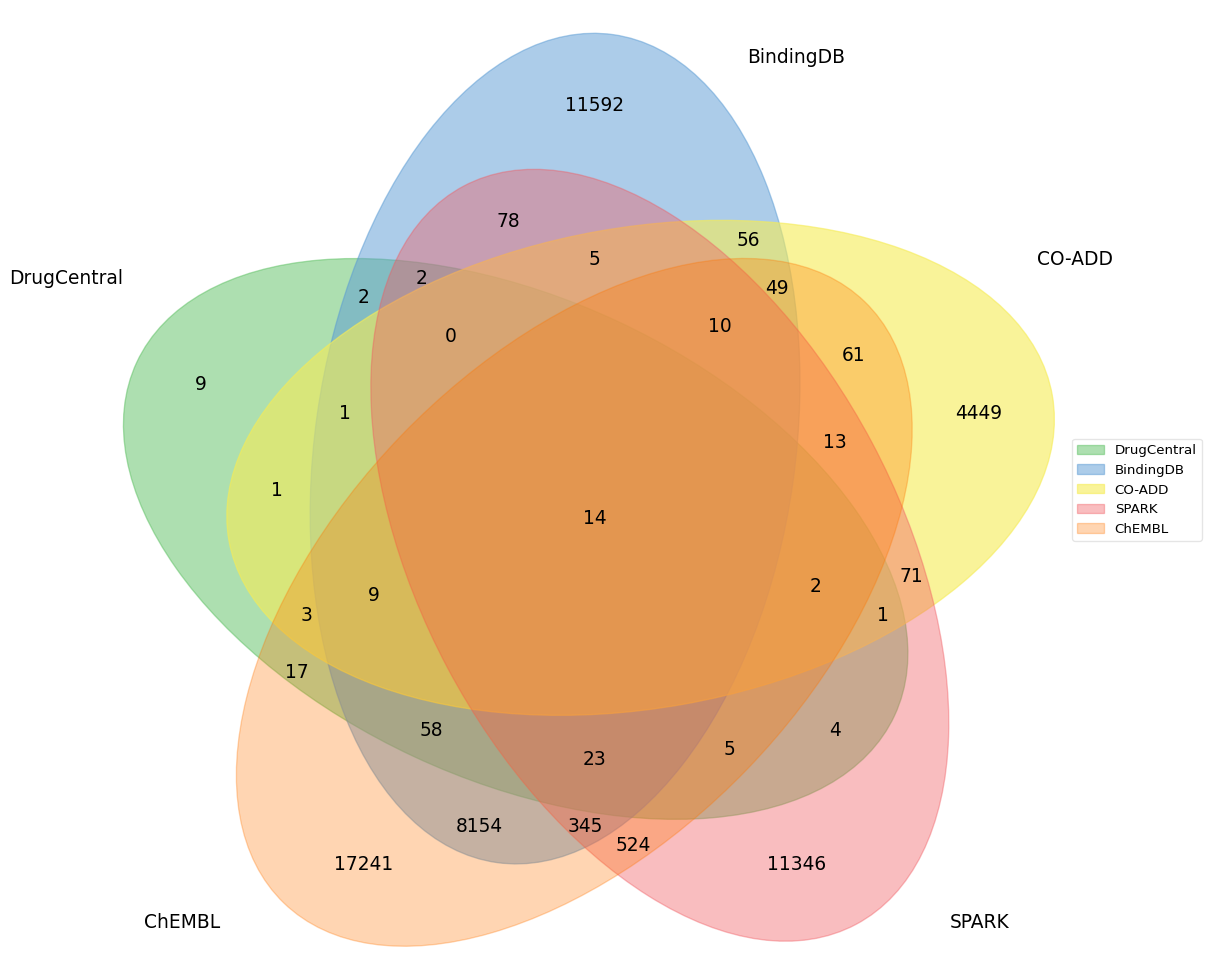

In [7]:
labels = get_labels([list(i) for _, i in source_cmp_set.items()])
fig = venn5(labels, names=list(source_cmp_set.keys()))
plt.savefig("../figures/figure_1.png", dpi=400, bbox_inches="tight")
plt.show()

# Normalizing data 
This step ensures that each compound-strain type category just has single row suitable for model training.

In [8]:
data_df = df.groupby(["inchikey", "strain"]).agg({"val": "max"}).reset_index()

In [9]:
cids = []
smiles = []

for inchikey, strain, val in tqdm(data_df.values):
    ref = df[
        (df["inchikey"] == inchikey) & (df["strain"] == strain) & (df["val"] == val)
    ]
    cid = ref["cmp_id"].values[0]
    cids.append(cid)

    smile = ref["smiles"].values[0]
    smiles.append(smile)

data_df["cmp_id"] = cids
data_df["smiles"] = smiles

100%|██████████| 63489/63489 [06:54<00:00, 153.35it/s]


In [10]:
data_df.head(3)

,inchikey,strain,val,cmp_id,smiles
0,AAAFNFZYVYYALD-UHFFFAOYSA-N,gram-positive,3.71,pubchem.compound:2850780,COCC(C)NCc1ccc(C)cc1C
1,AABJDBIUWZVBBU-UHFFFAOYSA-N,gram-negative,3.40,spark:SPK-0108052,FC1=CC=CC=C1N1C=C(CN2C=NC3=CC=CC=C23)N=N1
2,AABKQBNCAREVSD-UHFFFAOYSA-N,gram-positive,5.07,chembl:CHEMBL3601596,Cc1ccc(C2=C(O)COC2=O)cc1


In [11]:
# Unique compound-bact-activity pairs

final_list = []

unique_inchikeys = data_df["inchikey"].unique()

for inchikey in tqdm(unique_inchikeys):
    tmp = data_df[data_df["inchikey"] == inchikey]

    data_dict = tmp.to_dict("records")[0]

    if len(tmp) == 1:
        data_dict[data_dict["strain"]] = data_dict["val"]
    else:
        for row in tmp.to_dict("records"):
            data_dict[row["strain"]] = row["val"]

    final_list.append(
        {
            "cmp_id": data_dict["cmp_id"],
            "inchikey": data_dict["inchikey"],
            "smiles": data_dict["smiles"],
            "gram-negative": data_dict.get("gram-negative", 0),
            "gram-positive": data_dict.get("gram-positive", 0),
            "acid-fast": data_dict.get("acid-fast", 0),
        }
    )

100%|██████████| 54145/54145 [01:41<00:00, 531.04it/s]


In [12]:
amr_df = pd.DataFrame(final_list)
amr_df.head(2)

,cmp_id,inchikey,smiles,gram-negative,gram-positive,acid-fast
0,pubchem.compound:2850780,AAAFNFZYVYYALD-UHFFFAOYSA-N,COCC(C)NCc1ccc(C)cc1C,0.0,3.71,0.0
1,spark:SPK-0108052,AABJDBIUWZVBBU-UHFFFAOYSA-N,FC1=CC=CC=C1N1C=C(CN2C=NC3=CC=CC=C23)N=N1,3.4,0.00,0.0


In [13]:
amr_df.shape

(54145, 6)

# Marking of dominant class from the three groups.

In [14]:
dominant_group_list = []

for gram_neg_val, gram_positive_val, af_val in tqdm(
    amr_df[["gram-negative", "gram-positive", "acid-fast"]].values
):
    # If one of the values is non-zero, we pick that as the dominant group
    if gram_neg_val == gram_positive_val == 0 and af_val != 0:
        dominant_group_list.append("acid-fast")
    elif gram_neg_val == af_val == 0 and gram_positive_val != 0:
        dominant_group_list.append("gram-positive")
    elif gram_positive_val == af_val == 0 and gram_neg_val != 0:
        dominant_group_list.append("gram-negative")

    # If two of the values are non-zero, we pick the one with the highest value
    elif gram_neg_val > gram_positive_val and gram_neg_val > af_val:
        dominant_group_list.append("gram-negative")
    elif gram_positive_val > gram_neg_val and gram_positive_val > af_val:
        dominant_group_list.append("gram-positive")
    elif af_val > gram_neg_val and af_val > gram_positive_val:
        dominant_group_list.append("acid-fast")
    else:
        if (
            (gram_neg_val == gram_positive_val)
            or (gram_neg_val == af_val)
            or (gram_positive_val == af_val)
        ):
            dominant_group_list.append("unselective")
        else:
            raise ValueError(gram_neg_val, gram_positive_val, af_val)

100%|██████████| 54145/54145 [00:00<00:00, 1561816.34it/s]


In [15]:
amr_df["best"] = dominant_group_list
amr_df.head(2)

,cmp_id,inchikey,smiles,gram-negative,gram-positive,acid-fast,best
0,pubchem.compound:2850780,AAAFNFZYVYYALD-UHFFFAOYSA-N,COCC(C)NCc1ccc(C)cc1C,0.0,3.71,0.0,gram-positive
1,spark:SPK-0108052,AABJDBIUWZVBBU-UHFFFAOYSA-N,FC1=CC=CC=C1N1C=C(CN2C=NC3=CC=CC=C23)N=N1,3.4,0.00,0.0,gram-negative


In [16]:
amr_df.to_csv("../data/processed/standardized_data.tsv", sep="\t", index=False)